In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import imutils
import time
import copy
from skimage import img_as_uint
from scipy.spatial.distance import cdist
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float
import matplotlib.patches as patches
from copy import deepcopy
from itertools import combinations
from skimage.filters import roberts
%matplotlib inline

In [2]:
def detect_upper_body(img):
    img_copy = np.copy(img)
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
    upper_body_cascade = cv2.CascadeClassifier('../descriptors/upper_mcs_body.xml')
    rectangles = upper_body_cascade.detectMultiScale(img_copy)
    rectangle_list = sorted(rectangles, key=lambda x: x[2] * x[3], reverse=True)
    x, y, w, h =  rectangle_list[0] if rectangle_list else [0,0,0,0]
    cv2.rectangle(img_copy, (x,y), (x+w,y+h),(0,255,0),2)
    image_cut = img_copy[y:y+h, x:x+w]
    plt.imshow(image_cut, cmap="gray")
    return image_cut, (x,y,w,h)

def find_contour(gray):
    gray_copy = np.copy(gray)
    lower = 80
    upper = 140
    gray_copy = cv2.GaussianBlur(gray_copy, (7, 7), 0)
    mask = cv2.inRange(gray_copy, lower, upper)
    thresh = cv2.bitwise_not(gray_copy, gray, mask=mask)
    thresh = cv2.threshold(thresh, 45, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    plt.imshow(thresh, cmap="gray")
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts

# DISTANCE FORMULA (PX): distance = np.sqrt( (maxRight[0] - maxLeft[0])**2 + (maxRight[1] - maxLeft[1])**2 )
def contour_transform(contour, x,y):
    cnt_copy = deepcopy(contour)
    for i, c in enumerate(contour):
        for j in range(len(c)):
            cnt_copy[i][j][0][0] = c[j][0][0] + x
            cnt_copy[i][j][0][1] = c[j][0][1] + y
    return cnt_copy

def extreme_contour_points(cnt, x, y):
    maxLeft = tuple(cnt[0][cnt[0][:,:,0].argmin()][0])
    maxRight = tuple(cnt[0][cnt[0][:,:,0].argmax()][0])

    for c in cnt:
        leftmost = tuple(c[c[:,:,0].argmin()][0])
        rightmost = tuple(c[c[:,:,0].argmax()][0])
        if leftmost < maxLeft and (leftmost != (0,0) and leftmost != (0+x, 0+y)):
            maxLeft = leftmost
        if rightmost > maxRight:
            maxRight = rightmost
#     print(f"Left: {maxLeft} | Right: {maxRight}")
    return maxLeft, maxRight

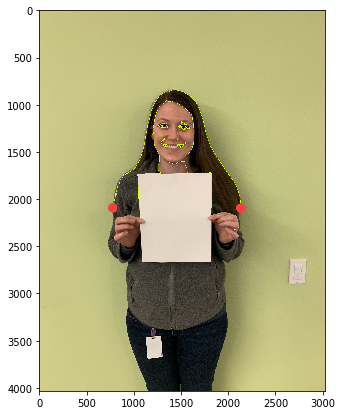

In [114]:
plt.rcParams['figure.figsize'] = [14.0, 7.0]

img = cv2.imread("../images/cora.jpg")
image_copy = np.copy(img)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
plt.imshow(image_copy)


upper_body_image, (x,y,w,h) = detect_upper_body(image_copy)
cnt = find_contour(upper_body_image)


_max_left, _max_right = extreme_contour_points(cnt, x, y)
_contour_lines = cv2.drawContours(upper_body_image, cnt, -1, (204, 255, 0), 3)
_contour_lines = cv2.circle(_contour_lines, _max_left, 50, (244, 66, 66), -1)
_contour_lines = cv2.circle(_contour_lines, _max_right, 50, (244, 66, 66), -1)
plt.imshow(_contour_lines)


transformed_contours = contour_transform(cnt, x, y)
max_left, max_right = extreme_contour_points(transformed_contours, x, y)
contour_lines = cv2.drawContours(image_copy, transformed_contours, -1, (204, 255, 0), 3)
contour_lines = cv2.circle(contour_lines, max_left, 50, (244, 66, 66), -1)
contour_lines = cv2.circle(contour_lines, max_right, 50, (244, 66, 66), -1)
plt.imshow(contour_lines)


Finding the rectangle coordinates


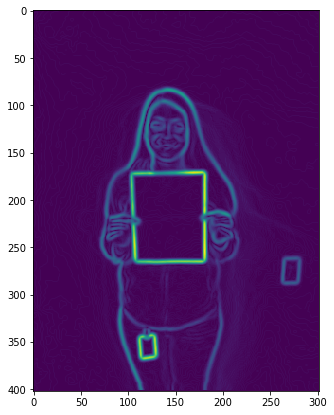

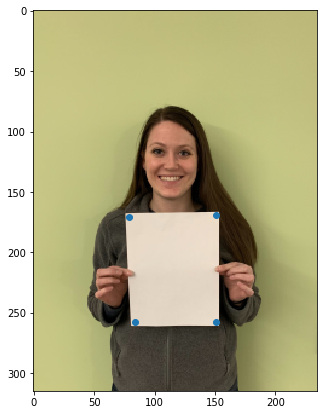

After applying the homography transformation


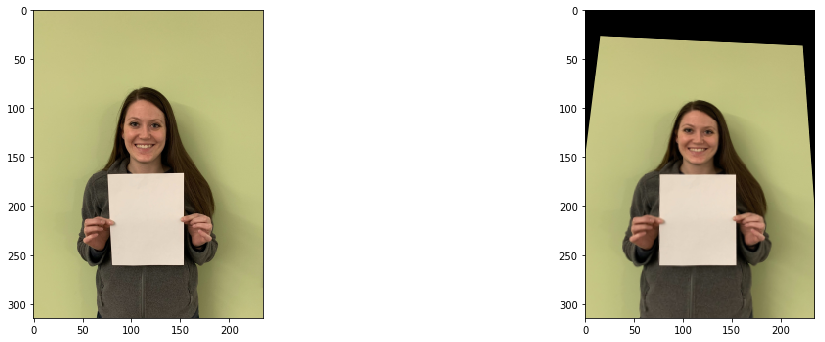

Width in inches:  18.335456554665715


In [118]:
np_left = np.array([max_left[0], max_left[1]])
np_right = np.array([max_right[0], max_right[1]])

r = 9
resize_factor = 0.1
r_img = imutils.resize(img, width=int(resize_factor*np.shape(img)[1]))
filt_img = cv2.GaussianBlur(r_img[:,:,0],(r,r),0)
img_roberts = roberts(filt_img)
plt.imshow(img_roberts)
img_roberts = cv2.normalize(src=img_roberts, dst=None, alpha=0, beta=255, 
               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)


#img_roberts.convertTo(img_roberts, CV_8UC1, 1/256.0)
cnts = cv2.findContours(img_roberts, mode = 3, method = 1)
cnts = cv2.findContours(img_roberts, cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

c_top, c_bottom = 5, 320
c_left, c_right = int(np_left[0] * resize_factor) - 50, int(np_right[0] * resize_factor) + 50
crop = img_roberts[c_top:c_bottom, c_left:c_right]
#crop = img_roberts[:,:]

bi = cv2.bilateralFilter(crop, 5, 75, 75)
dst = cv2.cornerHarris(bi, 2, 3, 0.04)

r_img_crop = r_img[c_top:c_bottom, c_left:c_right]
#r_img_crop = r_img[:,:]
mask = np.zeros_like(r_img_crop)

corners = dst > 0.1*dst.max()

r_img_copy = deepcopy(r_img[c_top:c_bottom, c_left:c_right,:])
#r_img_copy = deepcopy(r_img[:,:,:])
r_img_copy[corners] = [255,0,0]
# plt.imshow(r_img_copy)

corners_loc = np.where(corners)
xy_corners = list(zip(corners_loc[1], corners_loc[0]))


#Fuse points that are too close to each other
def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d):
    ret = []
    d2 = d * d
    n = len(points)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            count = 1
            point = [points[i][0], points[i][1]]
            taken[i] = True
            for j in range(i+1, n):
                if dist2(points[i], points[j]) < d2:
                    point[0] += points[j][0]
                    point[1] += points[j][1]
                    count+=1
                    taken[j] = True
            point[0] /= count
            point[1] /= count
            ret.append((point[0], point[1]))
    return ret

fused_corners = fuse(xy_corners, 5)
# print('Before Fusing:',len(xy_corners), 'After Fusing:',len(fused_corners))
xs = [p[0] for p in fused_corners]
ys = [p[1] for p in fused_corners]


index = list(range(0, len(fused_corners)))
index_combinations = list(combinations(index, 4))


def getXYforIndices(all_x, all_y, indices):
    x = []
    y = []
    for index in indices:
        x.append(all_x[index])
        y.append(all_y[index])
    return x, y

xy_combinations = []
for comb in index_combinations:
    #xy_combinations.append(getXYforIndices(corners_loc[1], corners_loc[0], comb))
    xy_combinations.append(getXYforIndices(xs, ys, comb))
    
    
to_remove = []
for xy_comb in xy_combinations:
    xy_distances = cdist(list(zip(xy_comb[0], xy_comb[1])), 
          list(zip(xy_comb[0], xy_comb[1])))
    not_rectangular = np.where((xy_distances > 0) & (xy_distances <= 5))
    
    if len(not_rectangular[0]) or len(not_rectangular[1]): 
        to_remove.append(xy_comb)
        
for r in to_remove:
    xy_combinations.remove(r)
    
def getClockwiseOrder(x, y):
    max2x = np.argpartition(x, -2)[-2:]
    max2y = np.argpartition(y, -2)[-2:]
    min2x = np.argpartition(x, 2)[:2]
    min2y = np.argpartition(y, 2)[:2]
    tl = np.intersect1d(min2x, min2y)
    tr = np.intersect1d(max2x, min2y)
    br = np.intersect1d(max2x, max2y)
    bl = np.intersect1d(min2x, max2y)
    if len(tl) and len(tr) and len(br) and len(bl):
        return x[np.concatenate((tl,tr,br,bl))], y[np.concatenate((tl,tr,br,bl))]
    else:
        return None, None
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

largest_area = 0
best_rectangle = ([],[])
for xy_comb in xy_combinations:
    x = np.array(xy_comb[0])
    y = np.array(xy_comb[1])
    x, y = getClockwiseOrder(x, y)
    if x is None or y is None:
        continue
    area = PolyArea(x, y)
    if area > largest_area:
        largest_area = area
        best_rectangle = (x, y)
        
fig, ax = plt.subplots(1)

r_img_crop_copy = cv2.cvtColor(r_img_crop, cv2.COLOR_BGR2RGB)
ax.imshow(r_img_crop_copy)
plt.scatter(best_rectangle[0], best_rectangle[1])
print("Finding the rectangle coordinates")
plt.show()

def find_coordinates(pts_src):
    pts_dst = np.zeros([4,2])
    
    w = pts_src[1,0] - pts_src[0,0]
    h = pts_src[3,1] - pts_src[0,1]
    
    pts_dst[0,0] = pts_src[0,0]
    pts_dst[0,1] = pts_src[0,1]
    
    pts_dst[1,0] = pts_src[0,0] + w 
    pts_dst[1,1] = pts_src[0,1] 
    
    pts_dst[2,0] = pts_src[0,0] + w 
    pts_dst[2,1] = pts_src[0,1] + h
    
    pts_dst[3,0] = pts_src[0,0]
    pts_dst[3,1] = pts_src[0,1] + h
    
    return pts_dst

pts_src = np.hstack((best_rectangle[0][np.newaxis].T, best_rectangle[1][np.newaxis].T))
pts_dst = find_coordinates(pts_src)


# Read source image.
im_src = cv2.cvtColor(deepcopy(r_img_crop), cv2.COLOR_BGR2RGB)

# Read destination image.
im_dst = cv2.cvtColor(deepcopy(r_img_crop), cv2.COLOR_BGR2RGB)
# Calculate Homography
h, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

# Display images
plt.subplot(131), plt.imshow(im_src)
plt.subplot(133), plt.imshow(im_out)
print("After applying the homography transformation")
plt.show()

a4_width_pixels = abs(pts_dst[0,0] - pts_dst[1,0]) 
pixel_width_inches = 8.5 / a4_width_pixels

left = np_left * resize_factor
right = np_right * resize_factor
left_v = np.append(left, 1)[np.newaxis].T
right_v = np.append(right, 1)[np.newaxis].T
left_after = np.dot(h, left_v)
right_after = np.dot(h, right_v)
left_after_xy = left_after/left_after[2]
right_after_xy = right_after/right_after[2]


shoulder_width_pixels = np.linalg.norm(left_after_xy[0:2]-right_after_xy[0:2])
shoulder_width_inches = shoulder_width_pixels * pixel_width_inches
print("Width in inches: ", shoulder_width_inches)

In [119]:
def clothes_size(length):
    if length < 34:
        return "Small"
    elif 34 <= length < 39:
        return "Medium"
    elif 39 <= length < 45:
        return "Large"
    else:
        return "XLarge"
    
size = clothes_size(shoulder_width_inches * 2)
print("Narvar jacket size:", size)

Narvar jacket size: Medium
